In [18]:
import copy
import numpy as np
import pandas as pd

from src.common.functions import get_feature_importance
#%cd /home/heza7322/PycharmProjects/missing-value-handling-in-carts
%cd /Users/Henning/PycharmProjects/missing-value-handling-in-carts
import matplotlib.pyplot as plt
from src.binary_tree import BinaryTree
from src.trinary_tree import TrinaryTree
from src.weighted_tree import WeightedTree
from src.common.functions import get_indices, calculate_loss, fit_response


/Users/Henning/PycharmProjects/missing-value-handling-in-carts


Matplotlib is building the font cache; this may take a moment.


In [6]:
df = pd.read_csv('example_notebooks/data/diabetes.csv')

df['y'] = ['diabetes' if outcome==1 else 'no_diabetes' for outcome in df['Outcome']]
df.drop('Outcome',axis=1,inplace=True)
features = df.columns[:-1]
n = len(df)

In [7]:
# Test train split
df['test'] = False
index_train = np.random.choice(df.index,int(n*0.2))
df.loc[index_train,'test'] = True

max_depth = 3
min_samples_leaf = 5
tree_types = {'majority': BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='majority'),
              'mia':      BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='mia'),
              'trinary': TrinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf),
              'weighted': WeightedTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)}


In [10]:
# Missingness of different frequencies
missing_probs = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

dfs = {0: df.copy()}

for missing_prob in missing_probs[1:]:
    dfs[missing_prob] = dfs[np.round(missing_prob-0.1,1)].copy()
    for feature in features:
        available_index = dfs[missing_prob].loc[(~dfs[missing_prob][feature].isna())].index
        to_remove = np.random.choice(available_index,78)
        dfs[missing_prob].loc[to_remove,feature] = np.nan

In [11]:
# Fit trees
results = pd.DataFrame(columns = [key for key in tree_types], index = missing_probs)
for missing_prob in missing_probs:
    print(missing_prob)
    X_train = dfs[missing_prob].loc[~dfs[missing_prob]['test'],features]
    y_train = dfs[missing_prob].loc[~dfs[missing_prob]['test'],'y']
    X_test  = dfs[missing_prob].loc[dfs[missing_prob]['test'],features]
    y_test  = dfs[missing_prob].loc[dfs[missing_prob]['test'],'y']
    for tree_name in tree_types:
        tree = copy.deepcopy(tree_types[tree_name])
        tree.fit(X_train,y_train)

        y_hat = tree.predict(X_test)
        pct_error = (y_test!=y_hat).mean()
        results.loc[missing_prob,tree_name] = pct_error
        print(tree_name)

0
majority
mia
trinary
weighted
0.1
majority
mia
trinary
weighted
0.2
majority
mia
trinary
weighted
0.3
majority
mia
trinary
weighted
0.4
majority
mia
trinary
weighted
0.5
majority
mia
trinary
weighted
0.6
majority
mia
trinary
weighted
0.7
majority
mia
trinary
weighted
0.8
majority
mia
trinary
weighted
0.9
majority
mia
trinary
weighted
1
majority
mia
trinary
weighted


<AxesSubplot:>

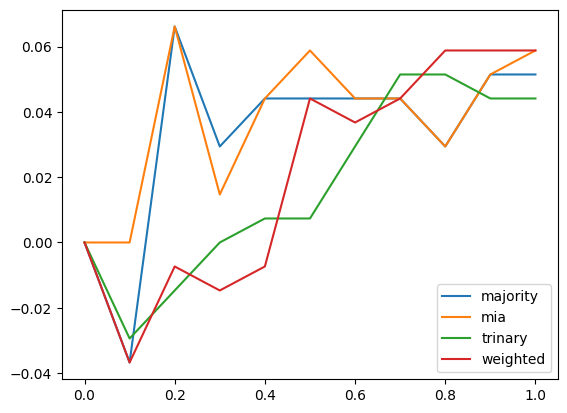

In [19]:
(results-results.loc[0]).plot()